In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/eggRE/original/'

image_data_generator = ImageDataGenerator(rescale=1./255)

generator = image_data_generator.flow_from_directory(
    root,
    target_size=(244, 244),
    batch_size=8,
    class_mode='binary'
)

print(generator.class_indices)

Found 794 images belonging to 2 classes.
{'Damaged': 0, 'NotDamaged': 1}


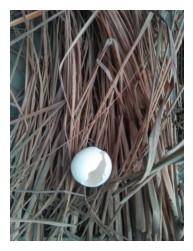

In [3]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(generator.filepaths[1]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')

show_image(image)

In [4]:
import pandas as pd

df = pd.DataFrame({'file_paths': generator.filepaths, 'targets': generator.classes})
df.loc[:, 'file_paths'] = df.file_paths.apply(lambda x: x.replace('\\', '/'))
df

,file_paths,targets
0,./datasets/eggRE/original/Damaged/damaged_1.jpg,0
1,./datasets/eggRE/original/Damaged/damaged_10.jpg,0
2,./datasets/eggRE/original/Damaged/damaged_100.jpg,0
3,./datasets/eggRE/original/Damaged/damaged_101.jpg,0
4,./datasets/eggRE/original/Damaged/damaged_102.jpg,0
...,...,...
789,./datasets/eggRE/original/NotDamaged/not_damag...,1
790,./datasets/eggRE/original/NotDamaged/not_damag...,1
791,./datasets/eggRE/original/NotDamaged/not_damag...,1
792,./datasets/eggRE/original/NotDamaged/not_damag...,1


In [5]:
df.targets.value_counts()

targets
0    632
1    162
Name: count, dtype: int64

#### 🤔 target의 분포 약 4배 정도 차이가 난다.
**🔍 Under Sampling으로 target의 분포를 맞춰보도록 하겠다.**

In [18]:
import pandas as pd
from sklearn.utils import resample

df_dmg = df[df['targets'] == 0]
df_ndmg = df[df['targets'] == 1]

print(df_dmg.count())
print('-' * 50)
print(df_ndmg.count())

file_paths    632
targets       632
dtype: int64
--------------------------------------------------
file_paths    162
targets       162
dtype: int64


In [19]:
df_dmg_down = resample(df_dmg, 
                       replace=False, 
                       n_samples=162, 
                       random_state=124).reset_index(drop=True)

df_dmg_down

,file_paths,targets
0,./datasets/eggRE/original/Damaged/damaged_192.jpg,0
1,./datasets/eggRE/original/Damaged/damaged_73.jpg,0
2,./datasets/eggRE/original/Damaged/damaged_422.jpg,0
3,./datasets/eggRE/original/Damaged/damaged_383.jpg,0
4,./datasets/eggRE/original/Damaged/damaged_340.jpg,0
...,...,...
157,./datasets/eggRE/original/Damaged/damaged_103.jpg,0
158,./datasets/eggRE/original/Damaged/damaged_196.jpg,0
159,./datasets/eggRE/original/Damaged/damaged_299.jpg,0
160,./datasets/eggRE/original/Damaged/damaged_543.jpg,0


In [20]:
df_dmg = df_dmg_down.copy()
df_dmg

,file_paths,targets
0,./datasets/eggRE/original/Damaged/damaged_192.jpg,0
1,./datasets/eggRE/original/Damaged/damaged_73.jpg,0
2,./datasets/eggRE/original/Damaged/damaged_422.jpg,0
3,./datasets/eggRE/original/Damaged/damaged_383.jpg,0
4,./datasets/eggRE/original/Damaged/damaged_340.jpg,0
...,...,...
157,./datasets/eggRE/original/Damaged/damaged_103.jpg,0
158,./datasets/eggRE/original/Damaged/damaged_196.jpg,0
159,./datasets/eggRE/original/Damaged/damaged_299.jpg,0
160,./datasets/eggRE/original/Damaged/damaged_543.jpg,0


In [24]:
df_ndmg = df_ndmg.reset_index(drop=True)
df_ndmg

,file_paths,targets
0,./datasets/eggRE/original/NotDamaged/not_damag...,1
1,./datasets/eggRE/original/NotDamaged/not_damag...,1
2,./datasets/eggRE/original/NotDamaged/not_damag...,1
3,./datasets/eggRE/original/NotDamaged/not_damag...,1
4,./datasets/eggRE/original/NotDamaged/not_damag...,1
...,...,...
157,./datasets/eggRE/original/NotDamaged/not_damag...,1
158,./datasets/eggRE/original/NotDamaged/not_damag...,1
159,./datasets/eggRE/original/NotDamaged/not_damag...,1
160,./datasets/eggRE/original/NotDamaged/not_damag...,1


In [26]:
df = pd.concat([df_dmg, df_ndmg]).reset_index(drop=True)
df

,file_paths,targets
0,./datasets/eggRE/original/Damaged/damaged_192.jpg,0
1,./datasets/eggRE/original/Damaged/damaged_73.jpg,0
2,./datasets/eggRE/original/Damaged/damaged_422.jpg,0
3,./datasets/eggRE/original/Damaged/damaged_383.jpg,0
4,./datasets/eggRE/original/Damaged/damaged_340.jpg,0
...,...,...
319,./datasets/eggRE/original/NotDamaged/not_damag...,1
320,./datasets/eggRE/original/NotDamaged/not_damag...,1
321,./datasets/eggRE/original/NotDamaged/not_damag...,1
322,./datasets/eggRE/original/NotDamaged/not_damag...,1


### 📋 Under Sampling 완료

#### 📌예측 세트, 훈련 세트, 검증 세트 분리

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(df.file_paths, df.targets, stratify=df.targets, test_size=0.2, random_state=124)

print(y_train.value_counts())
print(y_test.value_counts())

targets
1    130
0    129
Name: count, dtype: int64
targets
0    33
1    32
Name: count, dtype: int64


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=124)

print(y_train.value_counts())
print(y_val.value_counts())

targets
1    104
0    103
Name: count, dtype: int64
targets
1    26
0    26
Name: count, dtype: int64


In [29]:
import shutil
import os

root = './datasets/eggRE/'

for file_path in X_train:
    egg_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + egg_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [30]:
import shutil

root = './datasets/eggRE/'

for file_path in X_val:
    egg_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + egg_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [32]:
import shutil

root = './datasets/eggRE/'

for file_path in X_test:
    egg_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'test/' + egg_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 244

train_dir = './datasets/eggRE/train/'
validation_dir = './datasets/eggRE/validation/'
test_dir = './datasets/eggRE/test/'

train_data_generator = ImageDataGenerator(rescale=1./255)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='binary'
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='binary'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='binary'
)

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 207 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
{'Damaged': 0, 'NotDamaged': 1}
{'Damaged': 0, 'NotDamaged': 1}
{'Damaged': 0, 'NotDamaged': 1}


### 📌Cycle 7

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2

IMAGE_SIZE = 244

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=3, padding='same')(input_tensor)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)

x = Dense(500, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 244, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 244, 244, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 244, 244, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 122, 122, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 122, 122, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 122, 122, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 476288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 476288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │     238,144,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,405,673 (909.45 MB)

 Trainable params: 238,405,417 (909.44 MB)

 Non-trainable params: 256 (1.00 KB)

In [64]:
# 데이터 증강

import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def transform(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.CenterCrop(height=244, width=244, p=0.5),
        A.OneOf([
            A.ColorJitter(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
        ], p=0.5)
    ], p=0.5)

    return aug(image=image)['image']

In [65]:
idg = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)

train_generator = idg.flow_from_directory(
    './datasets/eggRE/train/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='binary'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    './datasets/eggRE/validation/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='binary'
)

Found 207 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [66]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(optimizer=Adam(learning_rate=1e-04), loss=BinaryCrossentropy(), metrics=['acc'])

In [67]:
mcp_cb = ModelCheckpoint(
    filepath="./callback_filesRE/cycle7_weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.keras",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min',
    min_lr=1e-7, 
    verbose=1
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

In [68]:
history = model.fit(
    train_generator,
    epochs=20,
    batch_size=8,
    validation_data=validation_generator,
    callbacks=[mcp_cb, rlr_cb, ely_cb],
)

AttributeError: module 'keras.src.backend' has no attribute 'standardize_data_format'